In [1]:
#!pip install py_vollib

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (4.8, 3.2)
import os

from tqdm.notebook import tqdm
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

import warnings 
warnings.filterwarnings('ignore') #to suppress warning messages
np.set_printoptions(suppress=True)

In [2]:
# Import your library (or specific modules from it)
from two_factor_quintic_ou import TwoFactorQuinticOUModel  # Import the model class
from two_factor_quintic_ou import gen_bm_path  # generating gaussian iid
from two_factor_quintic_ou import vec_find_iv_rat   # compute implied volatility

In [7]:
# Model parameters stored in a dictionary
model_params = {
    'theta': 0.94,
    'rho': -0.769,
    'lamda_x': 35.2,
    'lamda_y': 0.623,
    'p_k': np.array([0.0004, 0.0038, 0.0004, 0.0085, 0.0005, 1]),
}

In [8]:
# Forward variance stored in a dictionary - interpolated using cubic spline
model_fvc = {'T_nodes': np.array([0.0054757 , 0.03034648, 0.05521726, 0.08008804, 0.10495881,
       0.12982959, 0.15470037, 0.17957115, 0.20444193, 0.22931271,
       0.25418348, 0.27905426, 0.30392504, 0.32879582, 0.3536666 ,
       0.37853737, 0.40340815, 0.42827893, 0.45314971, 0.47802049,
       0.50289126, 0.52776204, 0.55263282, 0.5775036 , 0.60237438,
       0.62724516, 0.65211593, 0.67698671, 0.70185749, 0.72672827,
       0.88569473, 1.04466119, 1.20362765, 1.36259411, 1.52156057,
       1.68052704, 1.8394935 , 1.99845996, 2.15742642]), 
         'xi_nodes': np.array([2.34912589e-03,  1.27994132e-02,
        7.66709596e-03,  1.45531939e-02,  1.54914695e-02,  2.12614447e-02,
        6.75847550e-03,  2.96431743e-02,  2.10405860e-02,  3.94960055e-03,
        2.57702969e-02,  1.85988547e-02,  1.60362555e-02,  5.32291258e-02,
        3.09533754e-02,  6.25667003e-03,  2.47724879e-02,  4.52644497e-02,
        3.27610042e-02,  1.56279275e-02,  5.63122375e-02,  5.04134941e-02,
        8.64139752e-03,  7.67942525e-03,  2.14663805e-02,  2.26698876e-02,
        6.03566266e-02,  4.01883117e-02,  1.45574351e-02,  3.05791429e-02,
        4.31445724e-02,  3.49738453e-02,  3.23980298e-02,  4.48260139e-02,
        3.72399184e-02,  5.32035785e-02,  3.21367161e-02,  3.72093959e-02,
        5.89193262e-02])}

In [9]:
S_0 = 100.0
T_spx = 1/52
x1 = 0.0
x2 = 0.0

In [10]:
T_vix = 1/52
lm_vix = np.linspace(-0.1,1,40)
strike_perc_vix = np.exp(lm_vix)

lm = np.linspace(-0.2,0.03,40)
strikes = np.exp(lm)*S_0

In [11]:
model = TwoFactorQuinticOUModel(model_params, model_fvc)

## Individual examples

#### VIX pricing

In [14]:
%%time
Ft_quant, opt_quant, vix_iv_quant = model.vix_pricing_quantization(T_vix,strike_perc_vix)

CPU times: total: 0 ns
Wall time: 7.5 ms


In [15]:
np.random.seed(42)
N_sims = 400000
Z_mc = gen_bm_path(2,N_sims)

In [16]:
%%time
(vix_Ft_mc, vix_opt_mc, vix_opt_mc_std,vix_iv_iv_mc,vix_iv_iv_mc_u,vix_iv_iv_mc_l) = \
model.vix_pricing_mc(T_vix,strike_perc_vix,Z_mc)

CPU times: total: 1.22 s
Wall time: 1.24 s


#### SPX pricing

In [17]:
n_steps = 400
N_sims = 40000
w1 = gen_bm_path(n_steps,N_sims)

In [18]:
%%time
(spx_opt_mc, spx_opt_std, spx_iv_mc, spx_iv_u, spx_iv_l) =\
    model.spx_pricing_mc(x1,x2,S_0,T_spx,strikes,n_steps,N_sims,w1)

CPU times: total: 2.45 s
Wall time: 2.52 s


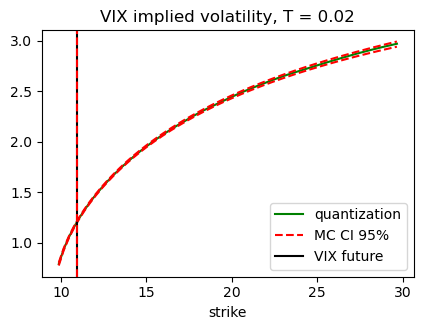

In [19]:
plt.title(f'VIX implied volatility, T = {round(T_vix,2)}')
plt.plot(strike_perc_vix*Ft_quant,vix_iv_quant,'g', label = 'quantization')
plt.plot(strike_perc_vix*vix_Ft_mc,vix_iv_iv_mc_u,'--r', label = 'MC CI 95%')
plt.plot(strike_perc_vix*vix_Ft_mc,vix_iv_iv_mc_l,'--r')
plt.xlabel('strike')
plt.axvline(x = Ft_quant, color = 'black', label = 'VIX future')
plt.axvline(x = vix_Ft_mc, color = 'red', ls = '--')
plt.legend()
plt.show()

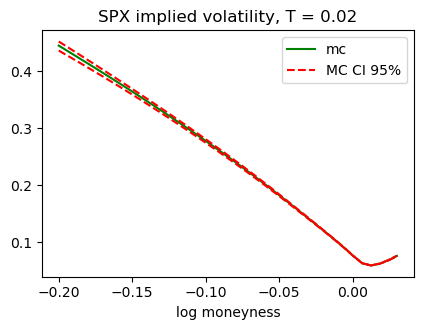

In [20]:
plt.title(f'SPX implied volatility, T = {round(T_spx,2)}')
plt.plot(lm,spx_iv_mc,'g', label = 'mc')
plt.plot(lm,spx_iv_u,'--r', label = 'MC CI 95%')
plt.plot(lm,spx_iv_l,'--r')
plt.xlabel('log moneyness')
plt.legend()
plt.show()

### SPX smiles

In [41]:
def spx_lm_range_rule(T_mat):
    ep_rule = 0.0001
    if T_mat<1/52+ep_rule:
        lm_range = [-0.1,0.03]
    elif T_mat<2/52+ep_rule:
        lm_range = [-0.15,0.03]
    elif T_mat <1/12+ep_rule:
        lm_range = [-0.25,0.03]
    elif T_mat < 2/12+ep_rule:
        lm_range = [-0.3,0.04]
    elif T_mat < 3/12+ep_rule:
        lm_range = [-0.4,0.08]
    elif T_mat < 6/12+ep_rule:
        lm_range = [-0.6,0.12]
    elif T_mat < 12/12+ep_rule:
        lm_range = [-0.8,0.15]
    else:
        lm_range = [-1.5,0.4]
    return lm_range

In [42]:
T_spx_array = np.array([0.03011636, 0.08213552, 0.183436  , 0.24093087, 0.42984257,
       0.64339493, 1.65913758, 2.15742642])
S_0 = 100.0

In [43]:
step_size_per_year = 252
total_n_steps = np.maximum(100,int(T_spx_array[-1]*step_size_per_year))
N_sims = 20000
np.random.seed(42)
w1_all=gen_bm_path(total_n_steps,N_sims)
strike_spx_array = []
for i in range(len(T_spx_array)):
    lm_temp = spx_lm_range_rule(T_spx_array[i])
    strike_spx_array.append(np.exp(np.linspace(lm_temp[0],lm_temp[1],50))*S_0)
strike_spx_array = np.array(strike_spx_array)
spx_iv_all = []
epochs_iter = tqdm(range(len(T_spx_array)), desc="iteration", miniters=1)
for i in epochs_iter:
    w1_temp = w1_all[:np.maximum(int(T_spx_array[i]*step_size_per_year),100)]
    n_steps = w1_temp.shape[0]
    (_, _, spx_iv_mc, _, _) = model.spx_pricing_mc(0.0,0.0,S_0,
                            T_spx_array[i],strike_spx_array[i],n_steps,N_sims,w1_temp)
    spx_iv_all.append(spx_iv_mc)
spx_iv_all = np.array(spx_iv_all)

iteration:   0%|          | 0/8 [00:00<?, ?it/s]

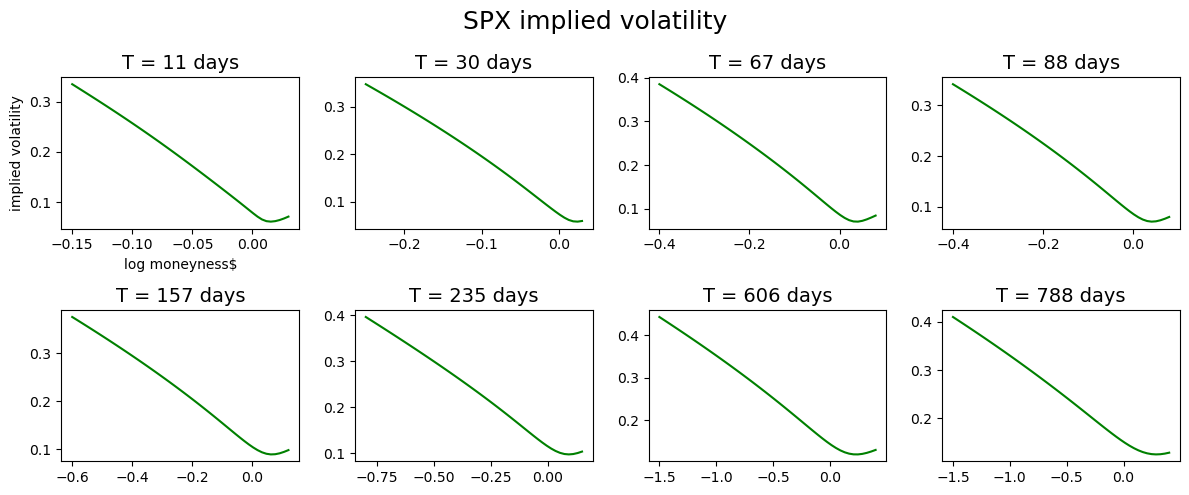

In [44]:
plt.figure(1,figsize=(12,5))
plt.suptitle('SPX implied volatility',fontsize=18)
for i in range(len(T_spx_array)):
    plt.subplot(2,4,i+1)
    if i ==0:
        plt.xlabel("log moneyness$",fontsize=10)
        plt.ylabel("implied volatility",fontsize=10)
    plt.title('T = {} days'.format(int(np.round(T_spx_array[i]*365.25,0))),fontsize=14)
    plt.plot(np.log(strike_spx_array[i]/S_0),spx_iv_all[i],'g')
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

### SPX skew stickiness ratio

In [25]:
T_ssr_array = np.array([1/52, 2/52, 1/12, 2/12, 3/12, 0.5,1,1.5,2])

In [26]:
spx_ssr_all = []
epochs_iter = tqdm(range(len(T_ssr_array)), desc="iteration", miniters=1)
for i in epochs_iter:
    w1_temp = w1_all[:np.maximum(int(T_ssr_array[i]*step_size_per_year),100)]
    n_steps = w1_temp.shape[0]
    spx_ssr_all.append(model.spx_ssr_mc(T_ssr_array[i],n_steps,N_sims,w1_temp))
spx_ssr_all = np.array(spx_ssr_all)

iteration:   0%|          | 0/9 [00:00<?, ?it/s]

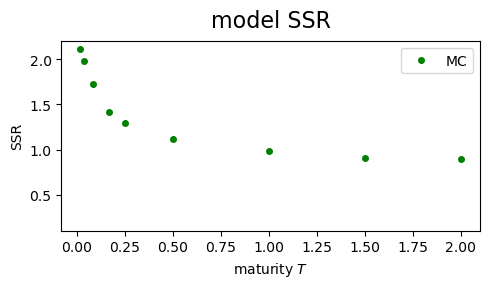

In [27]:
plt.figure(figsize=(5, 3))
plt.title("model SSR", size=16, y = 1.03)
plt.plot(T_ssr_array, spx_ssr_all, marker = "o",ls = '', color = 'green', ms=4, label="MC")
plt.xlabel(r"maturity $T$", fontsize = 10)
plt.ylabel("SSR", fontsize = 10)
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10)
plt.legend(fontsize = 10)
plt.ylim(0.1, 2.2)
plt.tight_layout()
plt.show()

### VIX smiles

In [28]:
T_vix_array = np.array([0.02464066, 0.06297057, 0.08213552, 0.15879535, 0.31211499,
       0.48459959])

In [29]:
strike_perc_vix_mins = np.array([0.94400028, 0.94124471, 0.92359907, 0.92696926, 0.91523008,
       0.91033437])
strike_perc_vix_maxs = np.array([1.91484922, 3.0199973 , 2.53358801, 4.04629642, 4.93758055,
       4.55585014])
strike_perc_vix_array = []
for i in range(len(T_vix_array)):
    strike_perc_vix_array.append(np.linspace(strike_perc_vix_mins[0],strike_perc_vix_maxs[1],50))
strike_perc_vix_array = np.array(strike_perc_vix_array)
vix_fut_all = []
vix_iv_all = []
epochs_iter = tqdm(range(len(T_vix_array)), desc="iteration", miniters=2)
for i in epochs_iter:
    vix_fut_temp, _, vix_iv_temp = model.vix_pricing_quantization(T_vix_array[i],strike_perc_vix_array[i])
    vix_fut_all.append(vix_fut_temp)
    vix_iv_all.append(vix_iv_temp)
vix_fut_all = np.array(vix_fut_all)
vix_iv_all = np.array(vix_iv_all)

iteration:   0%|          | 0/6 [00:00<?, ?it/s]

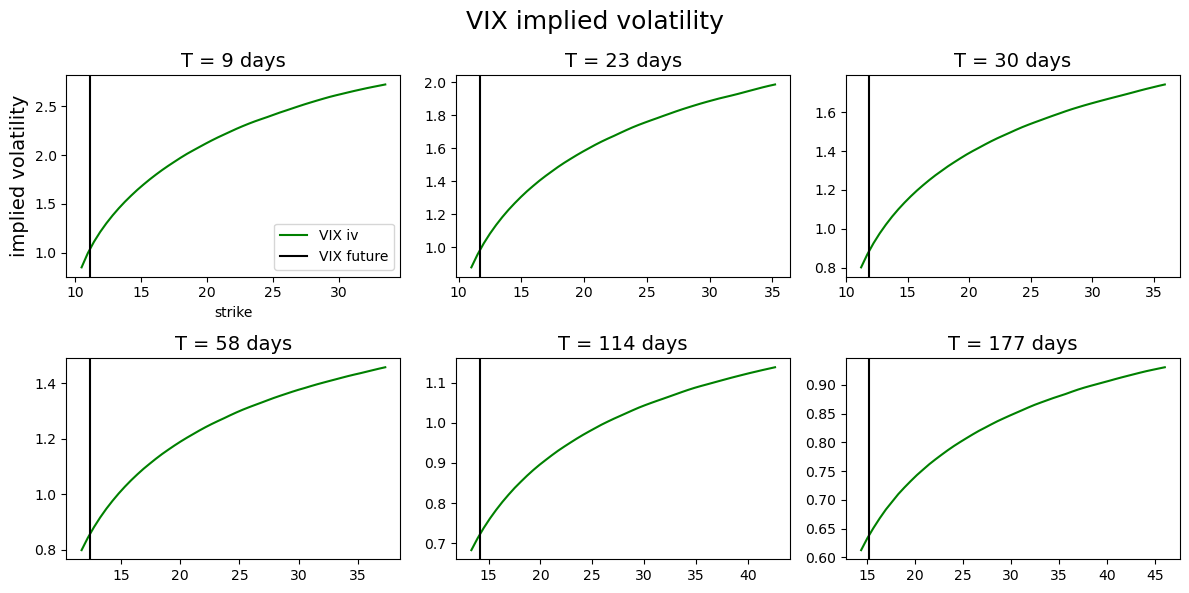

In [30]:
plt.figure(1,figsize=(12,6))
counter=1
plt.suptitle('VIX implied volatility',fontsize=18)
for i in range(len(T_vix_array)):
    plt.subplot(2,3,i+1)
    plt.title('T = {} days'.format(int(np.round(T_vix_array[i]*365.25,0))),fontsize=14)
    plt.plot(strike_perc_vix_array[i]*vix_fut_all[i],vix_iv_all[i],'g', label = 'VIX iv')
    plt.axvline(x = vix_fut_all[i], ls='-',color = 'black', label = 'VIX future')
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    if i ==0:
        plt.xlabel("strike",fontsize=10)
        plt.ylabel("implied volatility",fontsize=14)
        plt.legend()
plt.tight_layout()
plt.show()